# Scan rig crosstalk analysis

Background fluorescence in the 700 nm channel has been highlighted as a problem - particularly in scan rig 3, but also in the other two scan rigs. Narrowing the 700 channel emission filter will affect the % crosstalk performance. How much?

First perform setup, including setting relative paths of spectra files. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dye import Dye
from laser import Laser
from filterCube import FilterCube
from camera import Camera
from objective import Objective
import utils
from crosstalk_analysis import signalFromDyeXInChannelY
from crosstalk_analysis import displayCrosstalkPlot

dyesPath = 'Dye spectra/'
filtersPath = 'Filter spectra/'
opticsPath =  'Optics spectra/'
cameraPath = 'Camera spectra/'

__Sources for dye data:__

Atto general properties: https://www.atto-tec.com/fileadmin/user_upload/Katalog_Flyer_Support/Dye_Properties_01.pdf

Atto spectra: https://www.atto-tec.com/attotecshop/product_info.php?language=en&info=p117_ATTO-700.html

Alexa 405 absorption coefficient: http://www.atdbio.com/content/34/Alexa-dyes

Alexa 405 QY: http://confocal-microscopy-list.588098.n2.nabble.com/alexa-405-QY-td6913848.html

Alexa 405 spectra: https://www.chroma.com/spectra-viewer?fluorochromes=10533


__Sources for filter spectra:__

Semrock filters: http://www.laser2000.co.uk

Chroma 700 dichroics: emailed from Chroma


__Sources for camera spectra:__

Andor Zyla 5.5: https://searchlight.semrock.com/


__Sources for optics (objective) spectra:__

UPLANSAPO20x: https://www.olympus-lifescience.com/en/objectives/uplsapo/#!cms[tab]=%2Fobjectives%2Fuplsapo%2F20x, data extracted from curve using WebPlotDigitiser: http://arohatgi.info/WebPlotDigitizer/app/


Next, define (manually and in a boilerplate-y manner) the components of the system we are investigating. 

In [2]:
dye405 = Dye(name = 'Alexa405', epsilon = 35000, qy = 0.54, 
             absSpectrum = os.path.join(dyesPath, 'Alexa405abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'Alexa405em.txt'))
          
dye532 = Dye(name = 'Atto532', epsilon = 115000, qy = 0.9, 
             absSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.ems.txt'))

dye594 = Dye(name = 'Atto594', epsilon = 120000, qy = 0.85, 
             absSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.ems.txt'))

dye633 = Dye(name = "Atto655", epsilon = 125000, qy = 0.3, 
          absSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.ems.txt') )        

dye700 = Dye(name = "Atto700", epsilon = 120000, qy = 0.25, 
          absSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.ems.txt') )         
          
l405 = Laser(channel = 'L405Nm', centreWavelengthNm = 405, fwhmNm = 0.01, 
             laserOutputPowerMw = 3)
             
l532 = Laser(channel = 'L532Nm', centreWavelengthNm = 532, fwhmNm = 0.01, 
             laserOutputPowerMw = 18)
             
l594 = Laser(channel = 'L594Nm', centreWavelengthNm = 594, fwhmNm = 0.01, 
             laserOutputPowerMw = 25)             
          
l633 = Laser(channel = 'L633Nm', centreWavelengthNm = 640, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
          
l700 = Laser(channel = 'L700Nm', centreWavelengthNm = 701, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
             
fc405 = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R405', os.path.join(filtersPath, 'Di02-R405_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532 = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R532', os.path.join(filtersPath, 'Di02-R532_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R594', os.path.join(filtersPath, 'Di02-R594_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R635', os.path.join(filtersPath, 'Di02-R635_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
fc700old = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725dcxxr', os.path.join(filtersPath, 'Chroma 725dcxxr.txt') ), 
                   emissionFilter = ( 'FF01-795_150', os.path.join(filtersPath, 'FF01-795_150_Spectrum.txt') ) )
                   
fc700new = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725lpxr', os.path.join(filtersPath, 'Chroma 725lpxr.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )
                   
                   
camera = Camera(name = 'Andor Zyla 5.5', 
                qeCurve = os.path.join(cameraPath, 'Camera sCMOS (Andor- Zyla 5.5).txt'))

objective = Objective(name = 'Olympus UPLANSAPO20x 0.75NA', 
                      transmissionCurve = os.path.join(opticsPath, 'Olympus UPLANSAPO20x.txt'))



Perfom a direct comparison of the crosstalk from 633 dye into the old and new 700 nm detection channels. 

In [3]:
d, ch, sig = signalFromDyeXInChannelY(l700, fc700old, dye700, objective, camera)
d, ch, ct = signalFromDyeXInChannelY(l700, fc700old, dye633, objective, camera)

print('Crosstalk from 633 in old 700 channel as a % of signal:')
ct_old = 100*ct/sig
print(ct_old)

d, ch, sig = signalFromDyeXInChannelY(l700, fc700new, dye700, objective, camera)
d, ch, ct = signalFromDyeXInChannelY(l700, fc700new, dye633, objective, camera)

print('Crosstalk from 633 in new 700 channel as a % of signal:')
ct_new = 100*ct/sig
print(ct_new)


exTerm = 1448155.962
emTerm = 2.921
exTerm = 59009.339
emTerm = 1.596
Crosstalk from 633 in old 700 channel as a % of signal:
2.2269468069
exTerm = 1476697.707
emTerm = 1.692
exTerm = 60172.356
emTerm = 0.968
Crosstalk from 633 in new 700 channel as a % of signal:
2.33050476995


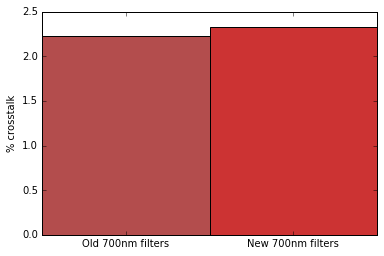

In [4]:
% matplotlib inline
plt.bar([1, 2], [ct_old, ct_new], width=[1, 1], tick_label=['Old 700nm filters', 'New 700nm filters'], 
        align='center', color=[(0.7 ,0.3, 0.3), (0.8, 0.2, 0.2)])
plt.ylabel('% crosstalk')

exTerm = 38952.607
emTerm = 6.427
exTerm = 1784.730
emTerm = 0.000
exTerm = 8380.286
emTerm = 0.000
exTerm = 3394.771
emTerm = 0.000
exTerm = 3103.790
emTerm = 0.000
exTerm = 0.000
emTerm = 0.006
exTerm = 919849.303
emTerm = 13.929
exTerm = 103662.121
emTerm = 0.162
exTerm = 33994.454
emTerm = 0.000
exTerm = 9598.434
emTerm = 0.000
exTerm = 0.000
emTerm = 0.000
exTerm = 1252.647
emTerm = 2.032
exTerm = 1087507.930
emTerm = 17.791
exTerm = 424808.417
emTerm = 2.520
exTerm = 145088.757
emTerm = 0.055
exTerm = 0.000
emTerm = 0.000
exTerm = 0.000
emTerm = 0.419
exTerm = 53588.834
emTerm = 5.685
exTerm = 1103273.914
emTerm = 4.821
exTerm = 617835.021
emTerm = 0.739
exTerm = 0.000
emTerm = 0.000
exTerm = 0.000
emTerm = 0.031
exTerm = 0.000
emTerm = 0.603
exTerm = 60172.356
emTerm = 0.968
exTerm = 1476697.707
emTerm = 1.692


C:\Users\d.kelly\Documents\DyeAnalysis\crosstalk_analysis.py:99: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(crosstalkMatrix), cmap = 'Reds', interpolation='none')


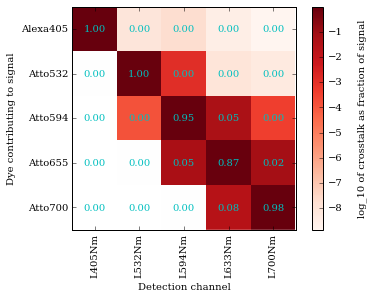

array([[  9.99999967e-01,   8.32246966e-09,   2.02958297e-08,
          3.18626450e-09,   1.39092151e-09],
       [  0.00000000e+00,   9.98690460e-01,   1.30952554e-03,
          9.46429892e-09,   5.23389386e-09],
       [  0.00000000e+00,   1.24617191e-04,   9.47078791e-01,
          5.24064051e-02,   3.90186601e-04],
       [  0.00000000e+00,   0.00000000e+00,   5.01077594e-02,
          8.74786200e-01,   7.51060407e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.27742917e-02,   9.77225708e-01]])

In [5]:
laser_list = [l405, l532, l594, l633, l700]
fc_list = [fc405, fc532, fc594, fc633, fc700new]
dye_list = [dye405, dye532, dye594, dye633, dye700]
displayCrosstalkPlot(laser_list, 
                     fc_list, 
                     dye_list, 
                     objective, camera)

## Chroma multiedge dichroic

If we could use a five-edge dichroic, we would significantly reduce the complexity of the instrument for wide field fluorescence. On the other hand, this is relatively expensive (Laser2000 suggest ~10k for Semrock, Chroma waiting for whether we're satisfied with spec before providing a quote) and locks us in to some extent to the current set of fluorophores. Perhaps most significantly, the increased complexity of the fabrication process will result in a performance drop in terms of signal in any one band. 

How bad is this performance drop? 

First, redefine 5 dummy cubes, where the dichroic is a common element and the excitation and emission filters are variable and placed in a filter wheel. For simplicity *at this point*, use the existing excitation and emission filters. 

In [6]:
fc405multi = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532multi = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594multi = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633multi = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
fc700multi = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Chroma multiedge', os.path.join(filtersPath, 'Chroma ZT405-532-594-640-701rpc.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )

multi_fc_list = [fc405multi, fc532multi, fc594multi, fc633multi, fc700multi]
                   

Then consider the relative (correct) signal from each of the dyes in their respective detection channels in the new system compared to the current system. Note that dye concentration is not considered so raw signal cannot be compared between channels, but that is is nevertheless valid to compare the two different setups in each channel individually. 

In [7]:
def show_dye_emission_enclosed_by_filters(dye, filtercube, objective, camera):
    """Given dye and filtercube, give visual indication of overlap"""
    
    dem = utils.interpolateSpectrum(dye.emissionSpectrum, 0.5)
    fem = utils.interpolateSpectrum(filtercube.emissionFilter.getSpectrum(), 0.5)
    fdiem = utils.interpolateSpectrum(filtercube.dichroicFilter.getSpectrum(), 0.5)
    spectra = [dem, fem, fdiem]
    
    lowerLimit = max( [min(spectrum[:,0]) for spectrum in spectra] )
    upperLimit = min( [max(spectrum[:,0]) for spectrum in spectra] )
    
    trimmedSpectra = [spectrum[(spectrum[:,0] >= lowerLimit) & (spectrum[:,0] <= upperLimit)] for spectrum in spectra]

    ovrlp = np.ones((trimmedSpectra[0][:,1].shape))
    
    for spectrum in trimmedSpectra:
        ovrlp = np.multiply(ovrlp, spectrum[:,1])
    
    hfig = plt.figure()
    plt.title(filtercube.channel)
    utils.displaySpectra(trimmedSpectra)
    plt.fill_between(trimmedSpectra[0][:,0], ovrlp)
        
    return np.sum(ovrlp)*0.5
          
    
    

exTerm = 38869.641
emTerm = 6.615
exTerm = 38952.607
emTerm = 6.427
L405Nm


<IPython.core.display.Javascript object>


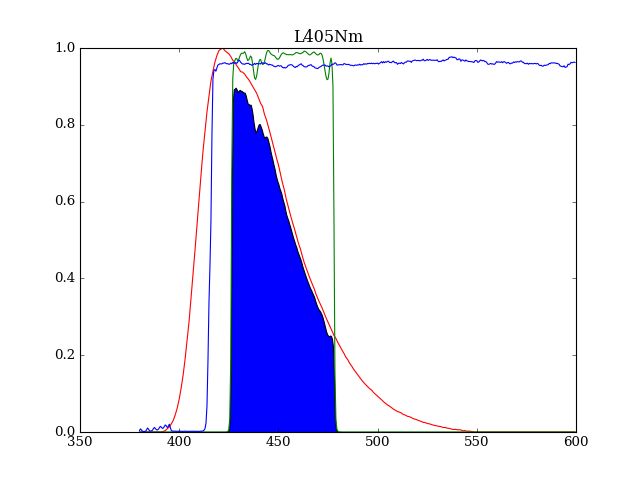

<IPython.core.display.Javascript object>


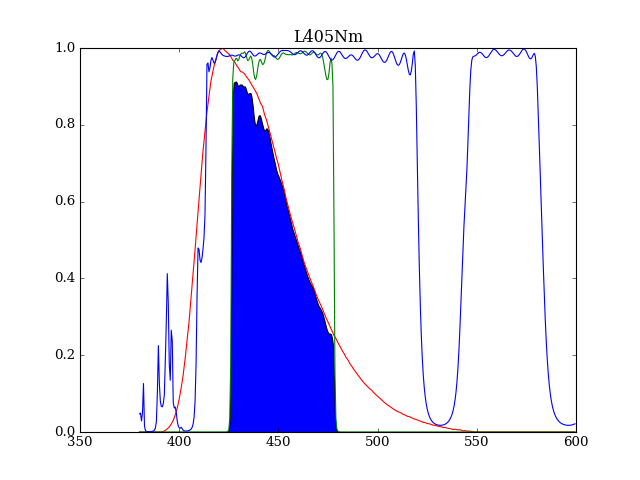

L405Nm
exTerm = 908001.108
emTerm = 13.313
exTerm = 919849.303
emTerm = 13.929
L532Nm


<IPython.core.display.Javascript object>


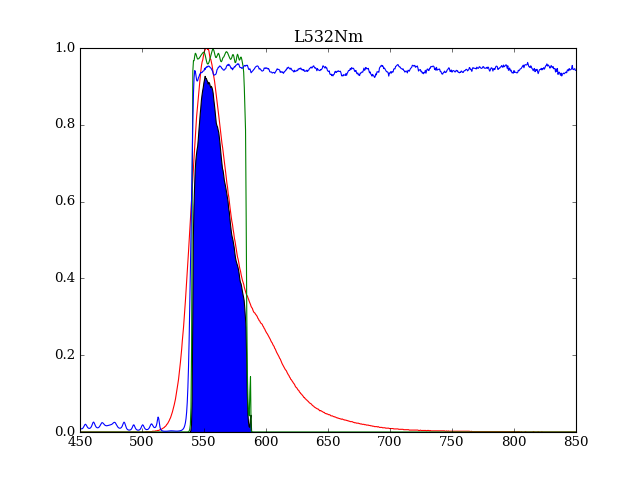

<IPython.core.display.Javascript object>


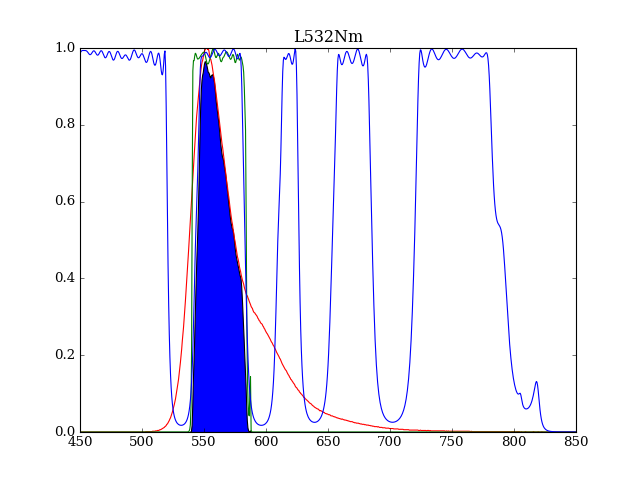

L532Nm
exTerm = 1080693.443
emTerm = 10.397
exTerm = 1087507.930
emTerm = 17.791
L594Nm


<IPython.core.display.Javascript object>


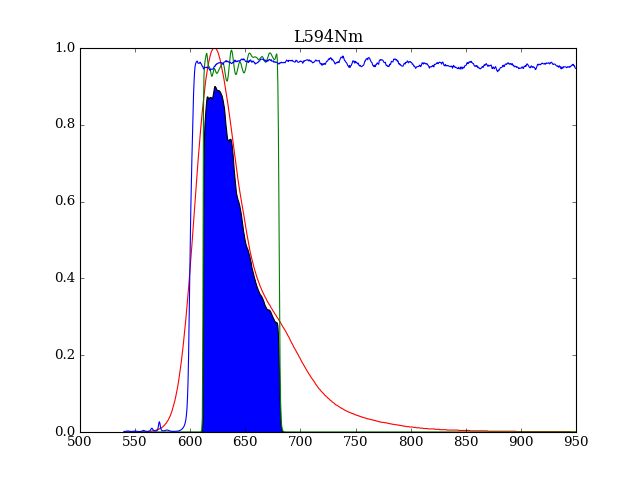

<IPython.core.display.Javascript object>


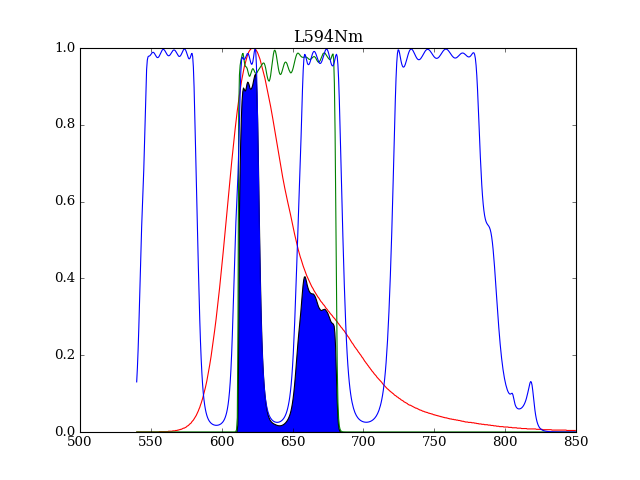

L594Nm
exTerm = 1079365.890
emTerm = 3.128
exTerm = 1103273.914
emTerm = 4.821
L633Nm


<IPython.core.display.Javascript object>


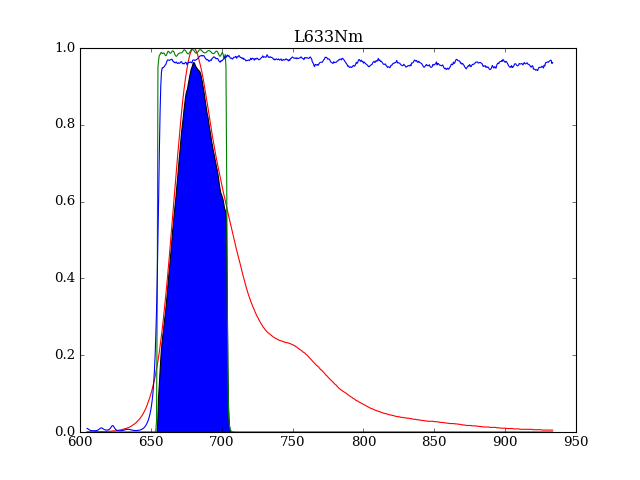

<IPython.core.display.Javascript object>


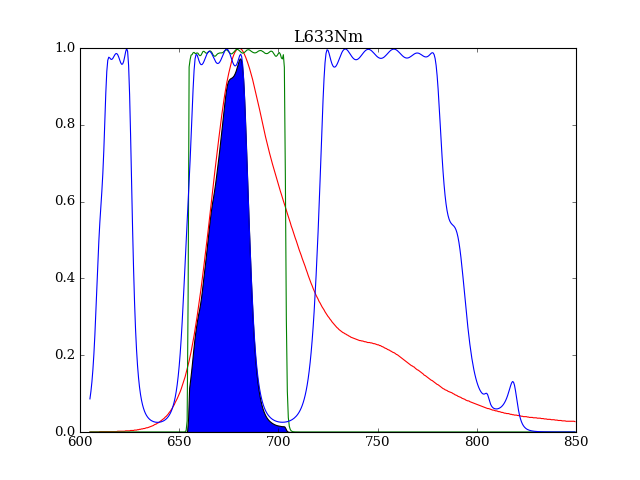

L633Nm
exTerm = 1476745.011
emTerm = 1.797
exTerm = 1476697.707
emTerm = 1.692
L700Nm


<IPython.core.display.Javascript object>


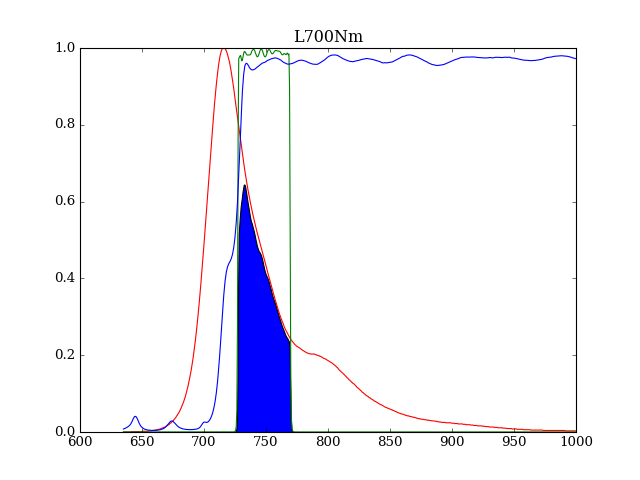

<IPython.core.display.Javascript object>


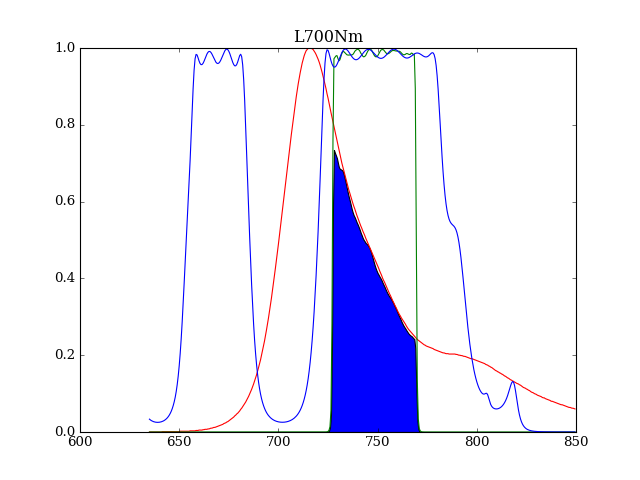

L700Nm
Ratios len = 5
Labels len = 5


<IPython.core.display.Javascript object>


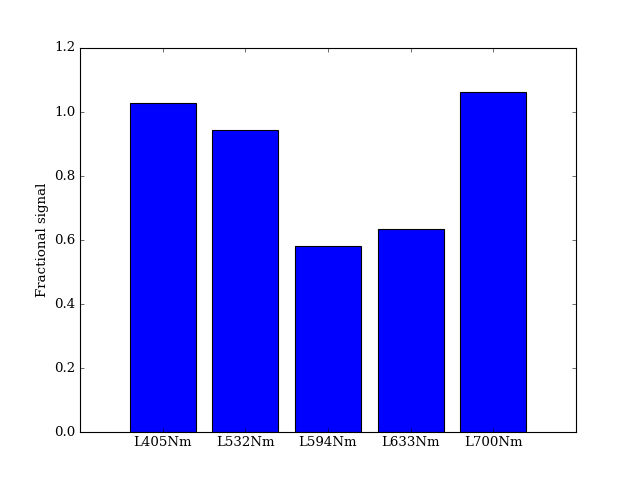

In [13]:
% matplotlib notebook
ratios = []
ch_labels = []

for l, f_old, f_new, dy in zip(laser_list, fc_list, multi_fc_list, dye_list):
    d, ch, sig_new = signalFromDyeXInChannelY(l, f_new, dy, objective, camera)
    d, ch, sig_old = signalFromDyeXInChannelY(l, f_old, dy, objective, camera)
    
    ratios.append(sig_new/sig_old)
    ch_labels.append(ch)
    print(ch)
    #print(sig_old)
    #print(sig_new)
    #print('Fraction = {}'.format(sig_new/sig_old))
    #fig = plt.figure();
    #plt.title('Old cubes, ' + ch + ' channel')
    #f_old.displaySpectra()
    #fig2 = plt.figure()
    #plt.title('Multiedge cube, ' + ch + ' channel')
    #f_new.displaySpectra()
    ol1 = show_dye_emission_enclosed_by_filters(dy, f_old, objective, camera)
    ol2 = show_dye_emission_enclosed_by_filters(dy, f_new, objective, camera)
    print(ch)
#     print('ol1 = {:0.3f}'.format(ol1 * dy.QY))
#     print('ol2 = {:0.3f}'.format(ol2 * dy.QY))

    
print('Ratios len = {}'.format(len(ratios)))
print('Labels len = {}'.format(len(ch_labels)))
    
fig3 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        ratios, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Fractional signal')
    